# MTH-IDS: A Multi-Tiered Hybrid Intrusion Detection System for Internet of Vehicles

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used.

### Preprocessing (normalization and padding values)

### Data sampling
 we sample a small-sized subset for model learning using **k-means cluster sampling**

### split train set and test set

In [4]:
# Read the sampled dataset
df=pd.read_csv('CICIDS2017_sample_km.csv')

In [5]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [6]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [7]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [9]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [10]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [11]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [12]:
X_fs = df[fs].values
X_fs

array([[-0.33605282, -0.5037086 , -0.49737083, ..., -0.44493072,
        -0.97686444, -0.22893453],
       [-0.33422169, -0.5037086 , -0.49737083, ..., -0.44493072,
        -0.97686444, -0.22893453],
       [-0.33422169, -0.5037086 , -0.49737083, ..., -0.44493072,
        -0.97686444, -0.22893453],
       ...,
       [-0.33614919,  0.50256986,  0.47989418, ..., -0.53712925,
         0.88692055,  0.76250084],
       [-0.33614919, -0.53214347, -0.51793682, ..., -0.53712925,
         0.88692055, -0.22893453],
       [-0.33614919, -0.53214347, -0.51793682, ..., -0.53712925,
         0.88692055, -0.22893453]])

In [13]:
X_fs.shape

(26800, 44)

### Feature selection by Fast Correlation Based Filter (FCBF)



In [14]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [15]:
X_fss = fcbf.fit_transform(X_fs,y)

In [16]:
X_fss.shape

(26800, 20)

### Re-split train & test sets after feature selection

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [18]:
X_train.shape

(21440, 20)

In [19]:
pd.Series(y_train).value_counts()

0.0    14580
3.0     2433
6.0     1744
1.0     1573
5.0     1004
2.0       77
4.0       29
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [20]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [21]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [22]:
pd.Series(y_train).value_counts()

0.0    14580
3.0     2433
6.0     1744
1.0     1573
5.0     1004
4.0     1000
2.0     1000
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9906716417910447
Precision of XGBoost: 0.9907925998356656
Recall of XGBoost: 0.9906716417910447
F1-score of XGBoost: 0.9907000129863451
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3645
         1.0       0.98      0.99      0.99       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      0.99      0.99       609
         4.0       0.71      0.71      0.71         7
         5.0       0.98      1.00      0.99       251
         6.0       0.96      0.99      0.98       436

    accuracy                           0.99      5360
   macro avg       0.95      0.95      0.95      5360
weighted avg       0.99      0.99      0.99      5360



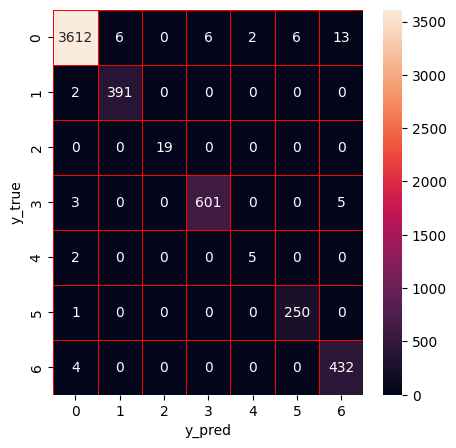

In [23]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)


In [24]:
!pip install hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████| 20/20 [00:31<00:00,  1.56s/trial, best loss: -0.996455223880597]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.2110137885129413, 'max_depth': 26.0, 'n_estimators': 95.0}


Accuracy of XGBoost: 0.996455223880597
Precision of XGBoost: 0.9964659852585694
Recall of XGBoost: 0.996455223880597
F1-score of XGBoost: 0.9964265124427766
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      0.99       393
         2.0       1.00      1.00      1.00        19
         3.0       1.00      1.00      1.00       609
         4.0       1.00      0.71      0.83         7
         5.0       0.99      1.00      0.99       251
         6.0       0.99      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       1.00      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



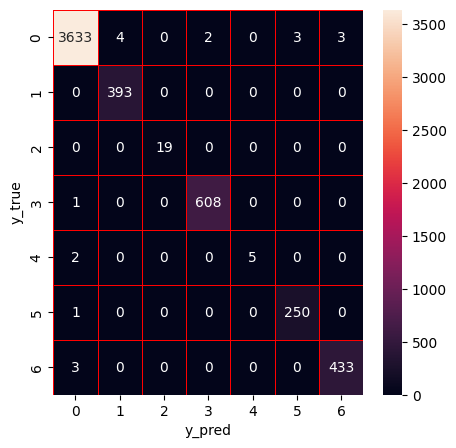

In [25]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [26]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.994776119402985
Precision of RF: 0.9947903249678829
Recall of RF: 0.994776119402985
F1-score of RF: 0.9947489362464502
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      1.00       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      0.99      0.99       609
         4.0       1.00      0.71      0.83         7
         5.0       0.99      1.00      0.99       251
         6.0       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       0.99      0.99      0.99      5360



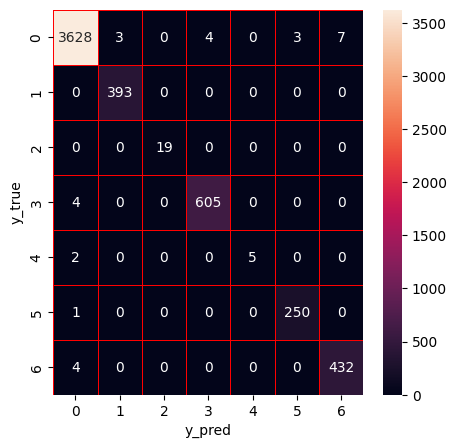

In [27]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)


In [28]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [05:00<00:00, 15.04s/trial, best loss: -0.9942164179104478]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 15.0, 'max_features': 10.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 61.0}


Accuracy of RF: 0.9951492537313433
Precision of RF: 0.9951695433029457
Recall of RF: 0.9951492537313433
F1-score of RF: 0.9951230332428121
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      0.99       393
         2.0       1.00      1.00      1.00        19
         3.0       1.00      1.00      1.00       609
         4.0       1.00      0.71      0.83         7
         5.0       0.98      1.00      0.99       251
         6.0       0.99      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



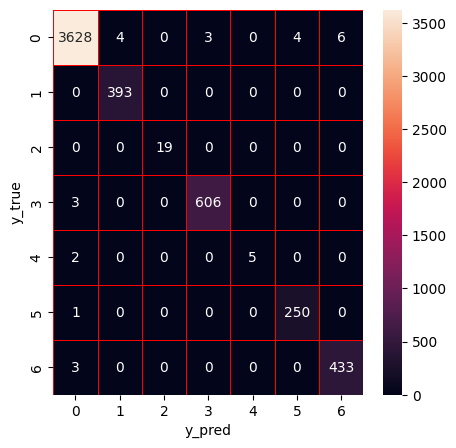

In [29]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [30]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9932835820895523
Precision of DT: 0.9940052730154401
Recall of DT: 0.9932835820895523
F1-score of DT: 0.9935669693954445
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      3645
         1.0       0.99      1.00      0.99       393
         2.0       0.95      1.00      0.97        19
         3.0       1.00      1.00      1.00       609
         4.0       0.38      0.71      0.50         7
         5.0       0.98      1.00      0.99       251
         6.0       0.98      0.99      0.99       436

    accuracy                           0.99      5360
   macro avg       0.90      0.96      0.92      5360
weighted avg       0.99      0.99      0.99      5360



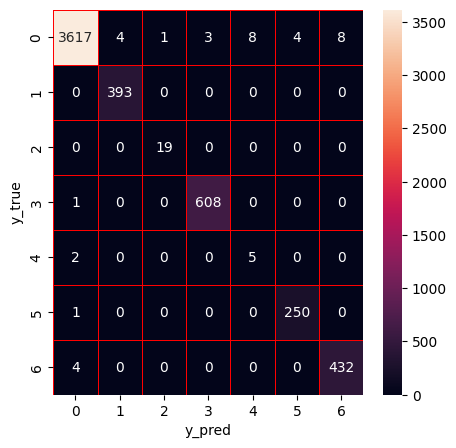

In [31]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)


In [32]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:11<00:00,  4.35trial/s, best loss: -0.9940298507462687]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 38.0, 'max_features': 10.0, 'min_samples_leaf': 1.0, 'min_samples_split': 9.0}


Accuracy of DT: 0.9925373134328358
Precision of DT: 0.9927107141754331
Recall of DT: 0.9925373134328358
F1-score of DT: 0.9926036146433211
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3645
         1.0       0.99      1.00      0.99       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      1.00      0.99       609
         4.0       0.56      0.71      0.63         7
         5.0       0.98      1.00      0.99       251
         6.0       0.99      0.98      0.98       436

    accuracy                           0.99      5360
   macro avg       0.93      0.95      0.94      5360
weighted avg       0.99      0.99      0.99      5360



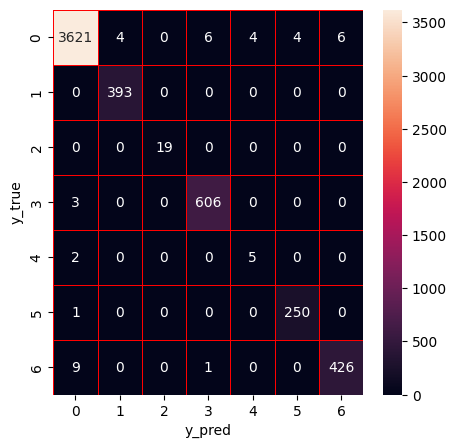

In [33]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [34]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9953358208955224
Precision of ET: 0.9953469945043185
Recall of ET: 0.9953358208955224
F1-score of ET: 0.9953070031881684
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      1.00       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      0.99      0.99       609
         4.0       1.00      0.71      0.83         7
         5.0       0.98      1.00      0.99       251
         6.0       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



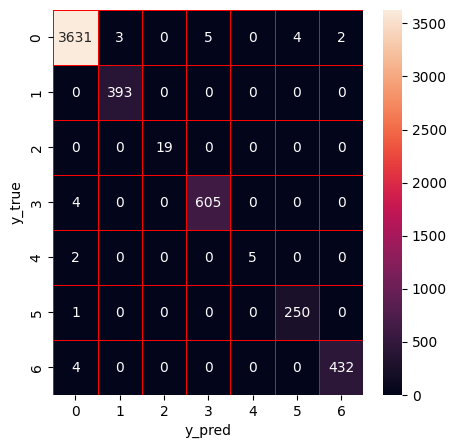

In [35]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)


In [36]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [01:19<00:00,  3.97s/trial, best loss: -0.9923507462686567]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 21.0, 'max_features': 20.0, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 128.0}


Accuracy of ET: 0.9957089552238806
Precision of ET: 0.9957255843854173
Recall of ET: 0.9957089552238806
F1-score of ET: 0.9956815406956562
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      1.00       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      1.00      0.99       609
         4.0       1.00      0.71      0.83         7
         5.0       0.98      1.00      0.99       251
         6.0       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



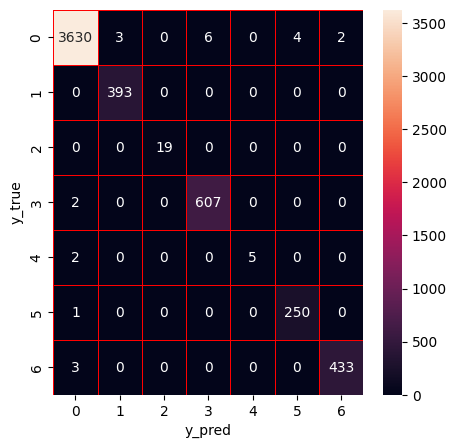

In [37]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [38]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [39]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0
2,1.0,1.0,1.0,1
3,0.0,0.0,0.0,0
4,3.0,3.0,3.0,3


In [40]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [41]:
dt_train.shape

(23334, 1)

In [42]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9955223880597015
Precision of Stacking: 0.9955382588150545
Recall of Stacking: 0.9955223880597015
F1-score of Stacking: 0.9954944403544314
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      1.00       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      1.00      0.99       609
         4.0       1.00      0.71      0.83         7
         5.0       0.98      1.00      0.99       251
         6.0       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



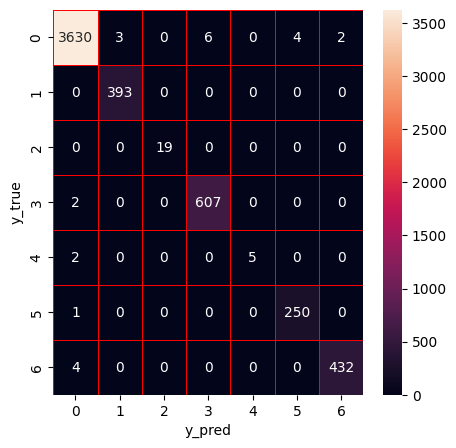

In [43]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)

In [44]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:07<00:00,  2.80trial/s, best loss: -0.9957089552238806]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.7381725100187848, 'max_depth': 56.0, 'n_estimators': 90.0}


Accuracy of XGBoost: 0.9955223880597015
Precision of XGBoost: 0.9955382588150545
Recall of XGBoost: 0.9955223880597015
F1-score of XGBoost: 0.9954944403544314
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3645
         1.0       0.99      1.00      1.00       393
         2.0       1.00      1.00      1.00        19
         3.0       0.99      1.00      0.99       609
         4.0       1.00      0.71      0.83         7
         5.0       0.98      1.00      0.99       251
         6.0       1.00      0.99      0.99       436

    accuracy                           1.00      5360
   macro avg       0.99      0.96      0.97      5360
weighted avg       1.00      1.00      1.00      5360



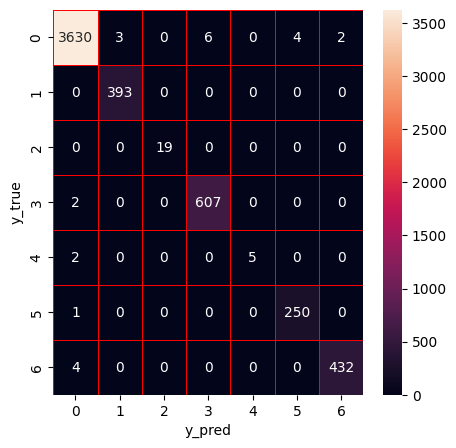

In [45]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [46]:
import joblib

# Save each base model to a separate file
joblib.dump(dt, 'decision_tree_model.joblib')
joblib.dump(rf, 'random_forest_model.joblib')
joblib.dump(et, 'extra_trees_model.joblib')
joblib.dump(xg, 'xgboost_model.joblib')

# Save the stacked model to a file
joblib.dump(stk, 'stacked_model.joblib')


['stacked_model.joblib']